# 03.3 Querying - Select Toy Profile

This notebook handles OCEL filtering to create a OCEL profile. We are interested in modeling: 
- How self-reported stress is affected by preceeding or concurrent physical activity bouts. 
- How a user engages in notifications triggering self-reports

## Setup 

In [1]:
import sys
sys.path.append('..')
from src.extended_ocel.read_json import read_json
import pm4py 
from pm4py.objects.ocel.importer import jsonocel 
from pm4py.algo.transformation.ocel.graphs import object_interaction_graph
from pm4py.visualization.ocel.object_graph import visualizer
from pm4py.visualization.ocel.object_graph.variants import graphviz
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.objects.conversion.heuristics_net import converter as hn_to_petri
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer


## Import OCED (standard)

In [2]:
path = "../data/ocel/standard_ocel_data_transformed.jsonocel"
ocel = jsonocel.variants.ocel20_standard.apply(path)
ocel.get_extended_table()

,ocel:eid,ocel:timestamp,ocel:activity,stress,action,location,bout_type,lifecycle,location_type,ocel:type:player,ocel:type:day,ocel:type:stress_self_report,ocel:type:notification,ocel:type:location_segment,ocel:type:physical_activity_bout
0,23004ac0-c90f-4d05-84f2-f9454c9b4983,2025-03-20 15:39:28.698000+00:00,stress_self_report,6,NaN,NaN,NaN,NaN,NaN,[d360ac20-326e-4f6f-8113-baa47ef536ef],[f7397705-b95e-4127-9090-32e0297be74a],[39c34d2c-02ce-4720-8b38-e9a70009fdf8],NaN,NaN,NaN
1,d890dc56-b167-4927-ab17-8163a11268bb,2025-03-21 11:12:32.086000+00:00,stress_self_report,5,NaN,NaN,NaN,NaN,NaN,[d360ac20-326e-4f6f-8113-baa47ef536ef],[109925f4-92f9-4171-8de8-c158ce3c4bb9],[75422593-efdc-44e3-a93c-0ea025643582],NaN,NaN,NaN
2,82f3c438-04eb-47b3-9bd2-22bb0969135f,2025-03-24 12:16:29.428000+00:00,stress_self_report,5,NaN,NaN,NaN,NaN,NaN,[d360ac20-326e-4f6f-8113-baa47ef536ef],[5121b325-3d50-471f-b2d3-2ae1284a2645],[627f800e-8752-477c-bc91-972d74532435],NaN,NaN,NaN
3,2469bdad-88c1-41fc-b685-2dff65e902bd,2025-03-25 00:21:36.166000+00:00,stress_self_report,3,NaN,NaN,NaN,NaN,NaN,[d360ac20-326e-4f6f-8113-baa47ef536ef],[9494182d-f442-45a9-ae87-a7bcdfb145c5],[1c9fd423-07f8-4d44-9387-86db57f7e234],NaN,NaN,NaN
4,2da792e3-2132-4f92-9751-bcd114f4f872,2025-03-25 03:22:13.885000+00:00,stress_self_report,3,NaN,NaN,NaN,NaN,NaN,[d360ac20-326e-4f6f-8113-baa47ef536ef],[9494182d-f442-45a9-ae87-a7bcdfb145c5],[e11fee9a-3114-43b4-8bb0-2e7e4a25ae7f],NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,b2cd2bc3-0855-4ed1-bcae-ae0385e8cb66,2025-05-25 13:18:18+00:00,location_event,NaN,NaN,NaN,NaN,Exiting,invalid,[d360ac20-326e-4f6f-8113-baa47ef536ef],[8d47453a-6a5c-454d-806a-971b71a11d8f],NaN,NaN,NaN,NaN
1172,20cf75f2-4fb6-4387-836f-ca1ad6e179cc,2025-05-25 13:18:18+00:00,location_event,NaN,NaN,NaN,NaN,Entering,home,[d360ac20-326e-4f6f-8113-baa47ef536ef],[8d47453a-6a5c-454d-806a-971b71a11d8f],NaN,NaN,NaN,NaN
1173,14e45d2f-4d93-408b-abbc-aad687e02126,2025-05-25 13:55:20+00:00,location_event,NaN,NaN,NaN,NaN,Exiting,home,[d360ac20-326e-4f6f-8113-baa47ef536ef],[8d47453a-6a5c-454d-806a-971b71a11d8f],NaN,NaN,NaN,NaN
1174,63cbb17b-1fe6-4e13-bb11-07318d03320c,2025-05-25 13:55:20+00:00,location_event,NaN,NaN,NaN,NaN,Entering,invalid,[d360ac20-326e-4f6f-8113-baa47ef536ef],[8d47453a-6a5c-454d-806a-971b71a11d8f],NaN,NaN,NaN,NaN


## Query OCED by Object Type

In [ ]:
#queried_ocel = pm4py.filter_ocel_object_types(ocel, ['day', 'stress_self_report', 'physical_activity_bout', 'notification'])
#pm4py.ocel_object_type_activities(queried_ocel)

In [ ]:
# filter on object entities
object_ids = [
    '51eb9cbc-bbd8-4635-9db2-c38007af73cb', 
    'ce6a104b-d813-4795-bd62-5408b44a71e4', 
    '33ea9eba-1239-4e4e-b640-d06e9108dbe4', 
    '7a3cd322-d1d3-40a8-975a-885428e90af1', 
    '5bfda6e8-d096-4bdf-a0ae-947e4740803e', 
    'e3e52c73-c6ef-401c-896d-18c7c5061c79', 
    '5bfda6e8-d096-4bdf-a0ae-947e4740803e', 
    'de849696-7ab0-4467-b3de-dbf0e67a26a9', 
    'de849696-7ab0-4467-b3de-dbf0e67a26a9', 
    'e3e52c73-c6ef-401c-896d-18c7c5061c79', 
    'ce6a104b-d813-4795-bd62-5408b44a71e4', 
    'd4b34322-7bb1-4d1d-8c4f-26629983db21', 
    '51eb9cbc-bbd8-4635-9db2-c38007af73cb', #
    'd4b34322-7bb1-4d1d-8c4f-26629983db21',
    'a29d49cb-0173-4135-8c51-fa0b0a003185',
    'e3e52c73-c6ef-401c-896d-18c7c5061c79',
    'de849696-7ab0-4467-b3de-dbf0e67a26a9',
    'c7906ca0-2344-4260-948d-7c749f8fcf7b'
]

# Filter
toy_profile = pm4py.filter_ocel_objects(ocel, object_ids, level=1)
toy_profile_df = toy_profile.get_extended_table()
filtered = toy_profile_df[
    (toy_profile_df["action"] != "READ") &
    (toy_profile_df["ocel:eid"] != "d67fbaa4-b631-48a1-adb2-9dff1e758aee") &
    (toy_profile_df["ocel:eid"] != "e1e51728-d6ef-440d-ad7c-7d8df7f3b99e") &
    (toy_profile_df["ocel:eid"] != "f4f3e354-770b-4a09-90fe-323e729321b7") &
    (toy_profile_df["ocel:eid"] != "28e8e60c-fea1-40b6-8fed-9b319afbb33b") &
    (toy_profile_df["ocel:eid"] != "352b6f74-a234-49e4-8169-85a3cfa0e794") &
    (toy_profile_df["ocel:eid"] != "82954aa8-181d-47ff-a02e-ce64adbea99b")

]
filtered

,ocel:eid,ocel:timestamp,ocel:activity,stress,action,location,bout_type,lifecycle,location_type,ocel:type:stress_self_report,ocel:type:notification,ocel:type:physical_activity_bout
0,f548ce30-e314-4cd6-b67a-56d5a145abf4,2025-05-11 08:52:24.926000+00:00,notification,NaN,RECEIVED,home,NaN,NaN,NaN,[33ea9eba-1239-4e4e-b640-d06e9108dbe4],[7a3cd322-d1d3-40a8-975a-885428e90af1],NaN
2,33ef137b-e25a-4f7d-a2ac-bbbf050b0c3e,2025-05-11 08:52:47.901000+00:00,stress_self_report,3,NaN,NaN,NaN,NaN,NaN,[33ea9eba-1239-4e4e-b640-d06e9108dbe4],[7a3cd322-d1d3-40a8-975a-885428e90af1],NaN
3,cb63dfc9-2cfb-4d75-89af-c8e867f0f32b,2025-05-11 11:34:21.735000+00:00,physical_activity_bout_START,NaN,NaN,NaN,LIGHT_PA,NaN,NaN,[51eb9cbc-bbd8-4635-9db2-c38007af73cb],NaN,[d4b34322-7bb1-4d1d-8c4f-26629983db21]
4,3b8a7c7a-1cd7-4c65-843b-9c19c0c3cf8c,2025-05-11 11:35:26.695000+00:00,physical_activity_bout_END,NaN,NaN,NaN,LIGHT_PA,NaN,NaN,[51eb9cbc-bbd8-4635-9db2-c38007af73cb],NaN,[d4b34322-7bb1-4d1d-8c4f-26629983db21]
5,6e5d60f9-38e6-42cf-933e-4ffa74921892,2025-05-11 11:54:16.238000+00:00,notification,NaN,RECEIVED,other,NaN,NaN,NaN,[51eb9cbc-bbd8-4635-9db2-c38007af73cb],[a29d49cb-0173-4135-8c51-fa0b0a003185],NaN
6,1d6fe82b-f9da-4e58-a223-a2b0e168a834,2025-05-11 11:54:16.582000+00:00,notification,NaN,RECEIVED,other,NaN,NaN,NaN,NaN,[ce6a104b-d813-4795-bd62-5408b44a71e4],NaN
8,1b9e560c-6a39-47c9-af43-0b0cc0e60d70,2025-05-11 11:54:33.909000+00:00,stress_self_report,4,NaN,NaN,NaN,NaN,NaN,[51eb9cbc-bbd8-4635-9db2-c38007af73cb],[a29d49cb-0173-4135-8c51-fa0b0a003185],[d4b34322-7bb1-4d1d-8c4f-26629983db21]
12,f4f3e354-770b-4a09-90fe-323e729321b7,2025-05-11 17:48:56.735000+00:00,physical_activity_bout_START,NaN,NaN,NaN,MODERATE-VIGOROUS_PA,NaN,NaN,NaN,NaN,[c7906ca0-2344-4260-948d-7c749f8fcf7b]
13,28e8e60c-fea1-40b6-8fed-9b319afbb33b,2025-05-11 18:53:11.735000+00:00,physical_activity_bout_START,NaN,NaN,NaN,LIGHT_PA,NaN,NaN,[e3e52c73-c6ef-401c-896d-18c7c5061c79],NaN,NaN
14,352b6f74-a234-49e4-8169-85a3cfa0e794,2025-05-11 18:56:16.695000+00:00,physical_activity_bout_END,NaN,NaN,NaN,LIGHT_PA,NaN,NaN,[e3e52c73-c6ef-401c-896d-18c7c5061c79],NaN,NaN


{('de849696-7ab0-4467-b3de-dbf0e67a26a9', 'e3e52c73-c6ef-401c-896d-18c7c5061c79'), ('51eb9cbc-bbd8-4635-9db2-c38007af73cb', 'a29d49cb-0173-4135-8c51-fa0b0a003185'), ('5bfda6e8-d096-4bdf-a0ae-947e4740803e', 'de849696-7ab0-4467-b3de-dbf0e67a26a9'), ('51eb9cbc-bbd8-4635-9db2-c38007af73cb', 'd4b34322-7bb1-4d1d-8c4f-26629983db21'), ('5bfda6e8-d096-4bdf-a0ae-947e4740803e', 'e3e52c73-c6ef-401c-896d-18c7c5061c79'), ('33ea9eba-1239-4e4e-b640-d06e9108dbe4', '7a3cd322-d1d3-40a8-975a-885428e90af1'), ('a29d49cb-0173-4135-8c51-fa0b0a003185', 'd4b34322-7bb1-4d1d-8c4f-26629983db21')}


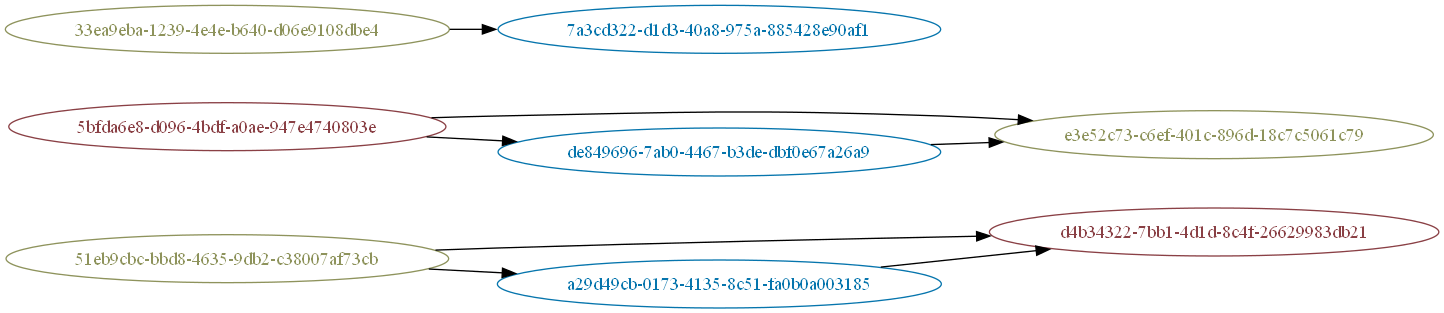

In [4]:
graph = object_interaction_graph.apply(toy_profile)
print(graph)
gviz=visualizer.apply(toy_profile, graph=graph, variant=graphviz)
visualizer.view(gviz)

Porfiles

## 5. Mining a toy Object Centric Petri Net

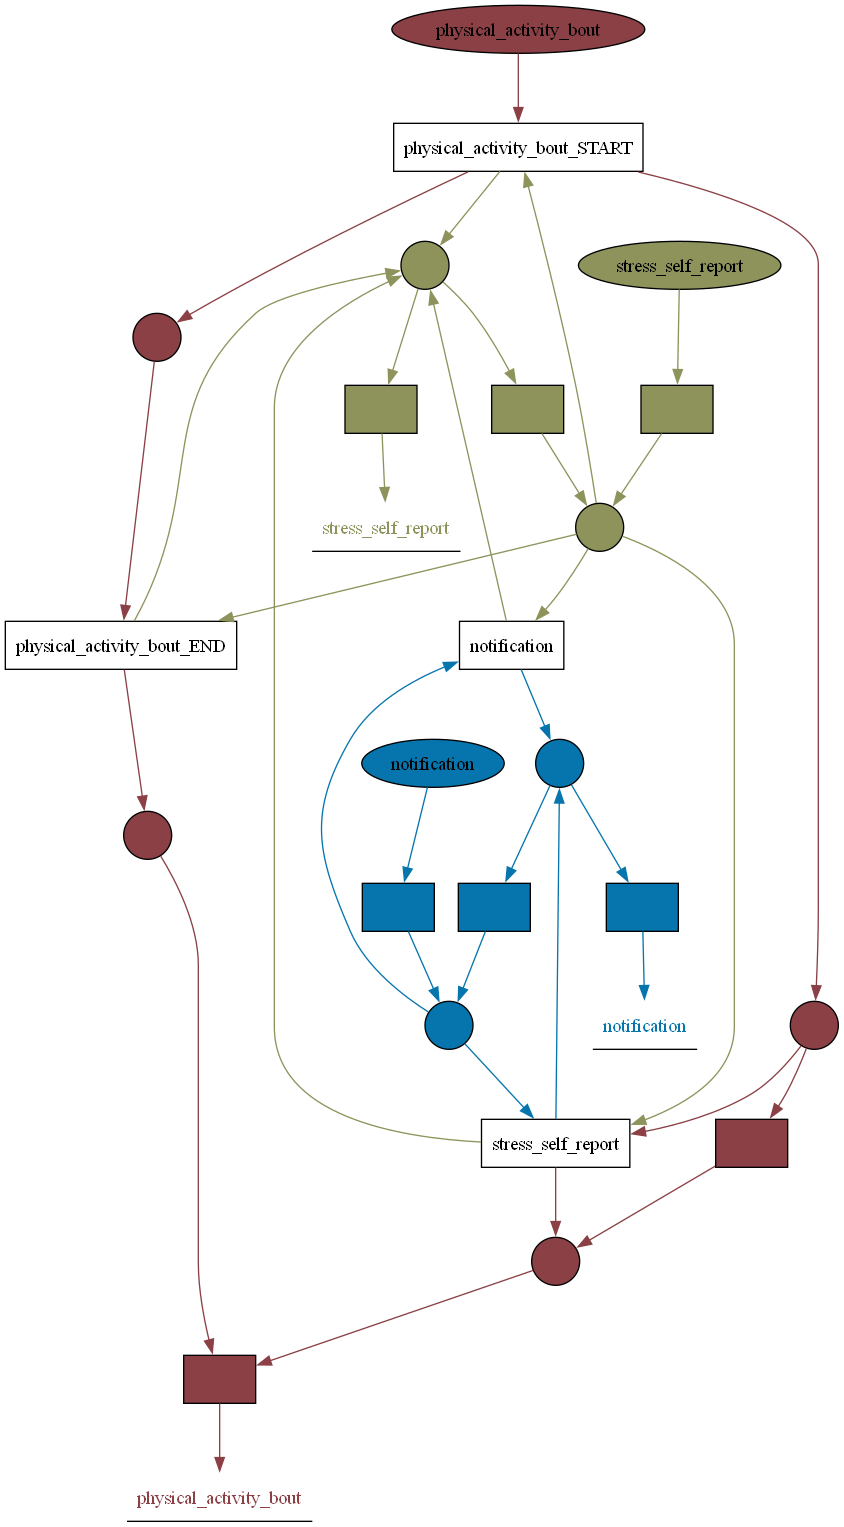

In [6]:
# Avoiding divergence problems
object_type_activities = pm4py.ocel_object_type_activities(toy_profile)
object_type_activities
#toy_profile= pm4py.filter_ocel_object_types_allowed_activities(toy_profile, {"notification": ["notification", "stress_self_report"], 
#                                                                                  "stress_self_report": [ "stress_self_report", "physical_activity_START", 
#                                                                                                         "physical_activity_END"],
#                                                                                                    
#                                                                                  "physical_activity_bout": ["physical_activity_START", "physical_activity_END"]})

model = pm4py.discover_oc_petri_net(toy_profile)
pm4py.view_ocpn(model,rankdir="TB")

In [ ]:
ocdfg = pm4py.discover_ocdfg(toy1_ocel_filtered)
pm4py.view_ocdfg(ocdfg)

Toy 2

In [ ]:
# Find self-report object IDs with stress_value > 6.0 and events with location == "home"
toy2_ocel = pm4py.read_ocel(f"../data/ocel/ocel_toy2_notification_pa_report_v2.jsonocel")
toy2_df = toy2_ocel.get_extended_table()
filtered = toy2_df[
    (toy2_df["ocel:activity"] == "stress_self_report") &
    (toy2_df["stress"].astype(float) > 4.0) &
    (toy2_df["location"] == "home")
]

qualified_object_ids= filtered["ocel:type:stress_self_report"].tolist()
qualified_object_ids.append(filtered["ocel:type:notification"])
flat_list = [item for sublist in qualified_object_ids for item in sublist]
unique_flat_list = list(set(flat_list))
print(unique_flat_list)

# Use PM4PY to filter the OCEL log
filtered_ocel = pm4py.filter_ocel_objects(toy2_ocel, qualified_object_ids, level=6)
objects_summary = pm4py.ocel_objects_summary(filtered_ocel)
objects_summary

In [ ]:

qualified_object_ids= ['7a3cd322-d1d3-40a8-975a-885428e90af1', '33ea9eba-1239-4e4e-b640-d06e9108dbe4']

In [ ]:
# Use PM4PY to filter the OCEL log
filtered_ocel = pm4py.filter_ocel_objects(toy2_ocel, qualified_object_ids, level=6)
objects_summary = pm4py.ocel_objects_summary(filtered_ocel)
objects_summary

In [ ]:
model = pm4py.discover_oc_petri_net(oce)
parameters = {
    "format": "png",
    "debug": False,
    "rankdir": "TB",
    "fontsize": 32,  # Increase font size for all text
    "fontname": "Arial",  # Use a clear font
    "fontsize_places": 32,  # Specific font size for places
    "fontsize_transitions": 32,  # Specific font size for transitions
    "fontsize_arcs": 12,  # Font size for arc labels
    "set_linewidth": 2.0,  # Make lines thicker for better visibility
    "set_margin": 0.5  # Add some margin around elements
}
pm4py.view_ocpn(model, rankdir="TB")